In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import gensim
import nltk
import re
import spacy
import en_core_web_sm
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import unicodedata
import regex as rx

from tqdm import tqdm
from pprint import pprint
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from nltk.stem import WordNetLemmatizer, SnowballStemmer

In [2]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dominik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
data = pd.read_csv('C:/Users/dominik/Desktop/Uni/Masterthesis/Data/Outputs/Scrape/220705_html_content_normalized.csv', sep=',')
data = data.sample(frac=1, random_state = 1)

In [4]:
data

,links,html_content,word_count
723,https://ethereals.wtf/#team,HOME\nSTORY\nROADMAP\nTEAM\nNFT BASICS\nFAQ\nD...,212
1012,https://superplastic.co/collections/frontpage/...,DEFAULT TITLE\nADD TO BAG\nCase Of 12 Blindbox...,12
1683,https://eulerbeats.com/,Drops\nStake\nDocs\nContact\nFutura is here!\n...,140
1717,https://www.coolcatsnft.com/competition-rules/...,CONNECT\nCool Cats Candy Bucket Giveaway Rules...,2863
1695,https://www.divineanarchy.com/edition-3-the-bu...,ABOUT\nFAQ\nNEWS\nPLAY NOW\nEDITION 3: THE BUR...,426
...,...,...,...
715,https://nfp.daz3d.com/frequently-asked-questions,NFPets\nPartnerships\nUtility\nRoadmap\nTeam\n...,221
905,https://www.dgenesis.io/collections/prime/drips,ARBIDRIPS MINT FOR BRIDGEOOORS IS NOW LIVE - M...,673
1096,https://0xadventures.com/,Adventure Cards\nDiscord\nOpensea\nTwitter\nCo...,82
235,https://tubbycats.club/@ratwell,Profilverzeichnis\nÜber diesen Server\nMobile ...,230


In [5]:
documents = data['html_content']
documents = pd.DataFrame(documents)

In [6]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

def remove_sandl_words(s,s_count,l_count):
    return ' '.join([w for w in s.split() if len(w)>s_count and len(w)<l_count])

In [7]:
def preprocess(df):

    # remove html tags from data
    df['text_preprocessed'] = df.iloc[:, 0].str.replace(r"->","")
    df['text_preprocessed'] = df.iloc[:, 1].str.replace(r"<-","")
    df['text_preprocessed'] = df.iloc[:, 1].str.replace(r"[","<")
    df['text_preprocessed'] = df.iloc[:, 1].str.replace(r"]",">")
    df['text_preprocessed'] = df.iloc[:, 1].apply(cleanhtml)

    #remove control characters
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: rx.sub(r'\p{C}', ' ',x))
    
    #remove emails
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: rx.sub(r'\S*@\S*\s?', '',x))
    
    # remove punctuation
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: re.sub(r'[,\.!?]', '', x))

    # remove words shorter than 3
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: remove_sandl_words(x,2,20))
    
    # change to lowercase letters
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: x.lower())
    
    return df

In [8]:
documents = preprocess(documents)

In [9]:
documents["word_count"] = documents['text_preprocessed'].str.split().str.len()

In [10]:
documents.head()

,html_content,text_preprocessed,word_count
723,HOME\nSTORY\nROADMAP\nTEAM\nNFT BASICS\nFAQ\nD...,home story roadmap team nft basics faq discord...,175
1012,DEFAULT TITLE\nADD TO BAG\nCase Of 12 Blindbox...,default title add bag case blindboxes single b...,9
1683,Drops\nStake\nDocs\nContact\nFutura is here!\n...,drops stake docs contact futura here futura th...,113
1717,CONNECT\nCool Cats Candy Bucket Giveaway Rules...,connect cool cats candy bucket giveaway rules ...,2340
1695,ABOUT\nFAQ\nNEWS\nPLAY NOW\nEDITION 3: THE BUR...,about faq news play now edition the bureau hel...,348


In [11]:
documents = documents[documents["word_count"]<10000]

In [12]:
num_words = documents["word_count"].sum()

In [13]:
num_words

698042

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuations

In [15]:
data = documents.text_preprocessed.values.tolist()
documents_words = list(sent_to_words(data))

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(documents_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [18]:
stop_words = stopwords.words('english')

stop_words.extend(stopwords.words('german'))

stop_words.extend(['blockchain','bitcoin','ethereum','technology','nft','nfts','mint','javascript','terms','condition','websites','terms','service'
                   ,'website','cookie','impressum','imprint','etc','cookies'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
# Remove Stop Words
data_words_nostops = remove_stopwords(documents_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
nlp.max_length = 1500000

# Do lemmatization keeping only noun
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])
print(data_lemmatized[:1])

[['home', 'story', 'roadmap', 'team', 'basic', 'shop', 'contact', 'eth', 'minting', 'est', 'origin', 'wormhole', 'sheet', 'fun', 'park', 'operator', 'chaos', 'operator', 'etherealtron', 'playing', 'sharing', 'ethereal', 'artist', 'ghost', 'player', 'community', 'ethereal', 'creator', 'banana', 'oil', 'painting', 'toy', 'icon', 'work', 'collection', 'world', 'brand', 'work', 'industry', 'publication', 'lead', 'artist', 'marketing', 'strategy', 'support', 'event', 'planning', 'event', 'partnership', 'hodler', 'marketing', 'community', 'head', 'social_media', 'strategist', 'event', 'manager', 'bayc', 'hodler', 'mnmlty', 'project', 'management', 'product', 'development', 'lead', 'developer', 'laser', 'falcon', 'brand', 'development', 'strategy', 'community', 'manager', 'engagement', 'strategy', 'bayc', 'hodler', 'ethereal', 'condition']]


In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 2), (4, 2), (5, 1), (6, 1), (7, 3), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 3), (17, 1), (18, 3), (19, 1), (20, 1), (21, 1), (22, 1), (23, 3), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 2), (31, 2), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 3), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1)]]


In [21]:
words_nouns = 0
for t in texts:
    x = len(t)
    words_nouns = words_nouns + x

In [22]:
words_nouns

200557

In [23]:
from multiprocessing import Process, freeze_support
if __name__ == "__main__":
    freeze_support()
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=8, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    # Print the Keyword in the 8 topics
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]

[(0,
  '0.020*"art" + 0.017*"collection" + 0.016*"community" + 0.016*"world" + '
  '0.014*"project" + 0.009*"piece" + 0.008*"space" + 0.008*"dgenesis" + '
  '0.008*"trait" + 0.007*"way"'),
 (1,
  '0.028*"use" + 0.026*"information" + 0.020*"site" + 0.019*"right" + '
  '0.018*"content" + 0.016*"service" + 0.015*"datum" + 0.014*"user" + '
  '0.012*"access" + 0.012*"agreement"'),
 (2,
  '0.016*"cat" + 0.013*"game" + 0.013*"time" + 0.012*"woman" + 0.011*"web" + '
  '0.011*"community" + 0.010*"experience" + 0.009*"company" + '
  '0.009*"cryptokittie" + 0.008*"team"'),
 (3,
  '0.063*"infinite_irl" + 0.041*"price" + 0.015*"server" + 0.014*"extension" + '
  '0.013*"web" + 0.012*"name" + 0.012*"parcel" + 0.011*"admit_one" + '
  '0.009*"cart" + 0.007*"listing"'),
 (4,
  '0.023*"collection" + 0.020*"wallet" + 0.019*"team" + 0.016*"contract" + '
  '0.014*"community" + 0.013*"opensea" + 0.012*"holder" + 0.011*"access" + '
  '0.011*"member" + 0.011*"claim"'),
 (5,
  '0.025*"wallet" + 0.023*"access" +

In [24]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, 
                                                  dictionary=id2word, 
                                                      coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.478558780926315


In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):

    coherence_values = []
    model_list = []

    for n_topics in tqdm(range(start, limit+1, step)):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics= n_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
total_num_topics = 20

In [27]:
models, cvalues = compute_coherence_values(id2word,corpus,texts,total_num_topics)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [08:22<00:00, 26.45s/it]


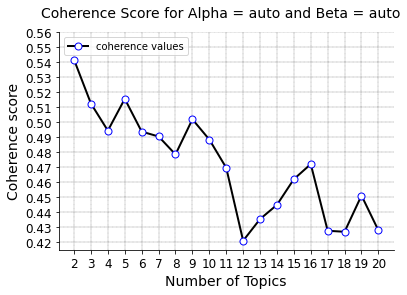

In [28]:
# Show graph
limit=total_num_topics; start=2; step=1;
x = range(start, limit+1, step)
y = cvalues

# predefine the graph results 
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [12.00, 6.00]
#plt.rcParams["figure.autolayout"] = True
ticksize = 12
labelsize = 14
markersize = 7
markercolor = 'blue'

#plot the graph
plt.plot(x, y, color='black', linestyle='-', linewidth = 2,
         marker='o', markerfacecolor='white', markeredgecolor=markercolor, markersize=markersize, label ="coherence values")

# define range on axes
plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize = ticksize)
plt.yticks(np.arange(round(min(y),2), max(y)+0.02, 0.01), fontsize = ticksize)

# name axes
plt.xlabel("Number of Topics", fontsize = labelsize)
plt.ylabel("Coherence score", fontsize = labelsize)

# title & legend
plt.suptitle("Coherence Score for Alpha = auto and Beta = auto", fontsize = 14, y = 0.97)
plt.legend(loc='upper left')

#remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

#grid
plt.grid(color = 'black',which = 'both', linestyle = '--', linewidth = 0.25)

# print plot
plt.show()

In [ ]:
from multiprocessing import Process, freeze_support
if __name__ == "__main__":
    freeze_support()
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=7, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    # Print the Keyword in the 10 topics
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]

In [30]:
def compute_coherence_values_a(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [31]:
grid = {}
grid['Validation_Set'] = {}

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.11))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.11))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm(total=len(alpha)*len(beta))
    
    # iterate through validation corpuses
    for a in alpha:
        # iterare through beta values
        for b in beta:
            # get the coherence score for the given parameters
            cv = compute_coherence_values_a(corpus=corpus, dictionary=id2word, 
                                          k=9, a=a, b=b)
            # Save the model results
            model_results['Topics'].append(9)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)

            pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()


  0%|                                                                                          | 0/110 [00:06<?, ?it/s]

 59%|███████████████████████████████████████████████▊                                 | 65/110 [37:43<20:12, 26.94s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [57:41<00:00, 31.47s/it]


In [32]:
model_res = pd.DataFrame(model_results)
model_res.sort_values(by = ['Coherence'],ascending = False)

,Topics,Alpha,Beta,Coherence
49,9,0.45,symmetric,0.530907
21,9,0.23,0.12,0.524371
29,9,0.23,symmetric,0.522632
50,9,0.56,0.01,0.522363
13,9,0.12,0.34,0.520662
...,...,...,...,...
70,9,0.78,0.01,0.446906
47,9,0.45,0.78,0.443578
38,9,0.34,0.89,0.442701
37,9,0.34,0.78,0.439395


In [33]:
best_alpha = 0.45
best_beta = 'symmetric'
best_num_top = 9

final_LDA_nouns = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=best_num_top, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=best_alpha,
                                           eta=best_beta)

coherence_LDA_nouns = compute_coherence_values_a(corpus=corpus, dictionary=id2word, 
                                          k=best_num_top, a=best_alpha, b=best_beta)

In [34]:
pprint(final_LDA_nouns.print_topics())

[(0,
  '0.023*"community" + 0.022*"collection" + 0.017*"project" + 0.016*"art" + '
  '0.013*"team" + 0.012*"world" + 0.012*"artist" + 0.010*"holder" + '
  '0.009*"time" + 0.008*"access"'),
 (1,
  '0.047*"information" + 0.028*"datum" + 0.021*"site" + 0.021*"service" + '
  '0.015*"use" + 0.015*"user" + 0.012*"access" + 0.011*"account" + '
  '0.011*"time" + 0.010*"privacy_policy"'),
 (2,
  '0.029*"cat" + 0.024*"creature" + 0.016*"cryptokittie" + 0.012*"token" + '
  '0.011*"wallet" + 0.010*"kitty" + 0.010*"gift" + 0.010*"time" + '
  '0.010*"swamp" + 0.009*"link"'),
 (3,
  '0.034*"price" + 0.025*"contract" + 0.024*"print" + 0.019*"home" + '
  '0.019*"club" + 0.018*"market" + 0.017*"auction" + 0.016*"sale" + '
  '0.016*"member" + 0.016*"detail"'),
 (4,
  '0.028*"rtfkt" + 0.026*"opensea" + 0.026*"claim" + 0.022*"wallet" + '
  '0.021*"product" + 0.020*"collection" + 0.018*"metaverse" + 0.017*"ape" + '
  '0.017*"contract" + 0.016*"phase"'),
 (5,
  '0.054*"wallet" + 0.033*"veefriend" + 0.032*"ca

In [35]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
topic_data = pyLDAvis.gensim_models.prepare(final_LDA_nouns, corpus, id2word) 
topic_data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.035621 -0.188890       1        1  25.791010
7      0.312232  0.021276       2        1  20.688864
1      0.263735  0.032758       3        1  19.951790
6     -0.119346 -0.209563       4        1   8.511765
4      0.036903 -0.050198       5        1   7.585090
3     -0.072935  0.051390       6        1   5.210236
5     -0.121032  0.031172       7        1   4.952592
2     -0.146668  0.035850       8        1   4.852074
8     -0.117267  0.276204       9        1   2.456578, topic_info=            Term         Freq        Total Category  logprob  loglift
384         game  1605.000000  1605.000000  Default  30.0000  30.0000
217  information  1874.000000  1874.000000  Default  29.0000  29.0000
464       wallet  1619.000000  1619.000000  Default  28.0000  28.0000
6     collection  1838.000000  1838.000000  Default  27.0000  27.0000
161        datum  1116.000000  1116.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
431          web   109.611484   449.161043   Topic9  -3.8055   2.2960
324       server    67.393725   262.794939   Topic9  -4.2919   2.3456
667      browser    68.066722   284.439775   Topic9  -4.2820   2.2764
773       submit    28.732045    60.031336   Topic9  -5.1444   2.9695
420         body    23.864120   142.155793   Topic9  -5.3301   1.9219

[515 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
63        1  0.263793      access
63        2  0.314950      access
63        3  0.292145      access
63        5  0.066565      access
63        7  0.062867      access
...     ...       ...         ...
58        5  0.010585       world
5378      8  0.975441  yakuza_cat
614       1  0.933087        year
614       3  0.065526        year
3852      5  0.973207         zoo

[838 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 2, 7, 5, 4, 6, 3, 9])

In [39]:
all_topics = {}
num_terms = 20 # Adjust number of words to represent each topic
lambd = 0.5 # Adjust this accordingly based on tuning above
for i in range(1,best_num_top+1): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [37]:
topic_words = pd.DataFrame(all_topics).T

In [38]:
topic_words

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Topic 1,community,project,collection,artist,team,world,art,piece,space,holder,year,people,dgenesis,trait,life,story,brand,mission,fren,drop
Topic 2,use,right,content,agreement,license,arbitration,transaction,purchase,provision,party,liability,dispute,owner,display,material,damage,app,network,loss,section
Topic 3,information,datum,service,site,account,security,email,privacy_policy,user,address,request,privacy,company,somnium_space,policy,provider,court,consent,business,purpose
Topic 4,game,player,play,farmer,voxie,land,eulerbeat,battle,revv,block,carrot,earn,weapon,farm,guardian,stake,world,gaming,genesis,car
Topic 5,rtfkt,ape,opensea,phase,buy,claim,crew,product,cryptozoo,egg,order,degen,gmoney,utility,metaverse,contract,gang,bear,ship,wallet
Topic 6,price,print,club,auction,gallery,market,membership,home,contract,view,bid,eth,burn,island,detail,download,member,bot,min_read,floor
Topic 7,veefriend,card,set,punk,wallet,blocknumber_number,veecon,wax,connect,duck,chibi,attribute,gold,horror,stay,chibi_lab,background,box,character,collection
Topic 8,cat,creature,cryptokittie,kitty,gift,swamp,robopet,icon,rabbit,winner,prize,breeding,boss_beautie,hoot,entry,chest,badge,profile,admission,stuff
Topic 9,infinite_irl,name,hornet,wife,binance,extension,axie,hok,genzeroe,faction,seal,soldier,axie_infinity,panel,fragment,comic_strip,web,lazy_cub,domain,migration


In [40]:
topic_words.to_csv("C:/Users/dominik/Desktop/Uni/Masterthesis/Data/Outputs/LDA/220707_topic_words_nouns.csv")

In [41]:
pyLDAvis.save_html(topic_data, '220711_pyLDA_nouns_NFT.html')

In [ ]:
!jupyter nbconvert --to html 220705_LDA_Model_NFT.ipynb

In [ ]:
# tabelize data to display in thesis
table_data = {
    "Model":["LDA_nouns"],
    "Words initial":[num_words],
    "Words after preprocess":[words_nouns],
    "Number of Topics":[best_num_top],
    "LDA Alpha":[best_alpha],
    "LDA Beta":[best_beta],
    "LDA coherrence":[coherence_LDA_nouns],
    "LDA Lambda":[lambd]
    }

table_inf = pd.DataFrame(table_data)

In [ ]:
table_inf